In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import MolFromSmiles

In [2]:
sns.set_theme(style='whitegrid')

In [3]:
PROPERTY_NAME = ('PLOGP', 'QED', 'SIMILARITY')[2]

In [4]:
INTRINSIC_TYPES = ('None', 'COUNTING', 'MEMORY', 'PREDICTION')

In [5]:
class CONFIGS:
    class CONFIGS_NONE:
        BUFFER_SIZE        = 1000
        SEQUENCE_MAXLEN    = 35
        INTRINSIC_WEIGHT   = '0.0' ###
        DISCOUNT_FACTOR    = '1.0'
        EPOCHS             = 4
        USE_L2NORM         = 'True'
        USE_GREEDY         = 'False'
        EPOCHS_PRED_NET    = 0
        ENTROPY_WEIGHT     = '0.01' ###
        FINGERPRINT_SIZE   = 256
        FINGERPRINT_RADIUS = 2
        LSH_SIZE           = 32
        
    class CONFIGS_CNT:
        BUFFER_SIZE        = 1000
        SEQUENCE_MAXLEN    = 35
        INTRINSIC_WEIGHT   = '0.01' ###
        DISCOUNT_FACTOR    = '1.0'
        EPOCHS             = 4
        USE_L2NORM         = 'True'
        USE_GREEDY         = 'False'
        EPOCHS_PRED_NET    = 0
        ENTROPY_WEIGHT     = '0.01' ###
        FINGERPRINT_SIZE   = 256
        FINGERPRINT_RADIUS = 2
        LSH_SIZE           = 32
        
    class CONFIGS_MEM:
        BUFFER_SIZE        = 1000
        SEQUENCE_MAXLEN    = 35
        INTRINSIC_WEIGHT   = '0.03' ###
        DISCOUNT_FACTOR    = '1.0'
        EPOCHS             = 4
        USE_L2NORM         = 'True'
        USE_GREEDY         = 'False'
        EPOCHS_PRED_NET    = 0
        ENTROPY_WEIGHT     = '0.01' ###
        FINGERPRINT_SIZE   = 256
        FINGERPRINT_RADIUS = 2
        LSH_SIZE           = 32
        
    class CONFIGS_PRED:
        BUFFER_SIZE        = 1000
        SEQUENCE_MAXLEN    = 35
        INTRINSIC_WEIGHT   = '0.04' ###
        DISCOUNT_FACTOR    = '1.0'
        EPOCHS             = 4
        USE_L2NORM         = 'True'
        USE_GREEDY         = 'False'
        EPOCHS_PRED_NET    = 0
        ENTROPY_WEIGHT     = '0.01' ###
        FINGERPRINT_SIZE   = 256
        FINGERPRINT_RADIUS = 2
        LSH_SIZE           = 32
        
    configs_none = CONFIGS_NONE()
    configs_cnt  = CONFIGS_CNT()
    configs_mem  = CONFIGS_MEM()
    configs_pred = CONFIGS_PRED()
    
    def __getitem__(self, k):
        if k == 'None':
            return self.configs_none
        elif k == 'COUNTING':
            return self.configs_cnt
        elif k == 'MEMORY':
            return self.configs_mem
        elif k == 'PREDICTION':
            return self.configs_pred
    
configs = CONFIGS()

In [6]:
def get_input_dir(prop_name, intrinsic_type, configs):
    input_dir = 'results'
    input_dir = os.path.join(input_dir, f'scoringFnc_{prop_name}')
    input_dir = os.path.join(input_dir, f'curiosityBufferSize_{configs[intrinsic_type].BUFFER_SIZE}')
    input_dir = os.path.join(input_dir, f'maxSL_{configs[intrinsic_type].SEQUENCE_MAXLEN}')
    input_dir = os.path.join(input_dir, f'intrinsicRewardType_{intrinsic_type}')
    input_dir = os.path.join(input_dir, f'intrinsicRewardWeight_{configs[intrinsic_type].INTRINSIC_WEIGHT}')
    input_dir = os.path.join(input_dir, f'discountFactor_{configs[intrinsic_type].DISCOUNT_FACTOR}')
    input_dir = os.path.join(input_dir, f'kEpochs_{configs[intrinsic_type].EPOCHS}')
    input_dir = os.path.join(input_dir, f'l2Curosity_{configs[intrinsic_type].USE_L2NORM}')
    input_dir = os.path.join(input_dir, f'greedyCuriosity_{configs[intrinsic_type].USE_GREEDY}')
    input_dir = os.path.join(input_dir, f'nEpochsPredNetwork_{configs[intrinsic_type].EPOCHS_PRED_NET}')
    input_dir = os.path.join(input_dir, f'entropyWeight_{configs[intrinsic_type].ENTROPY_WEIGHT}')
    input_dir = os.path.join(input_dir, f'fingerprintBits_{configs[intrinsic_type].FINGERPRINT_SIZE}')
    input_dir = os.path.join(input_dir, f'fingerprintRadius_{configs[intrinsic_type].FINGERPRINT_RADIUS}')
    input_dir = os.path.join(input_dir, f'lshBits_{configs[intrinsic_type].LSH_SIZE}')
    return input_dir

In [7]:
list_input_dir = [get_input_dir(PROPERTY_NAME, x, configs) for x in INTRINSIC_TYPES]

# 1. Best Molecule

In [8]:
def get_best_smiles(input_dir):
    filepath_best_smiles = os.path.join(input_dir, 'best_smiles_0.txt')

    with open(filepath_best_smiles) as fin:
        lines = fin.readlines()

    best_molecule_smiles = lines[0].rstrip().split(': ')[1]
    best_molecule_prop   = float(lines[1].rstrip().split(': ')[1])

    ## Reference: chem_env.calculate_score
    if PROPERTY_NAME == 'PLOGP':
        best_molecule_prop = best_molecule_prop * 10.
        
    return best_molecule_smiles, best_molecule_prop

In [9]:
for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_smiles, best_molecule_prop = get_best_smiles(input_dir)
    print('========', intrinsic_type, '========')
    print('>>> BEST SMILES:', best_molecule_smiles)
    print('>>> BEST PROP:', best_molecule_prop)
    print()

======== None ========
>>> BEST SMILES: CF
>>> BEST PROP: 0.027777777777777776

======== COUNTING ========
>>> BEST SMILES: CF
>>> BEST PROP: 0.027777777777777776

======== MEMORY ========
>>> BEST SMILES: C=1[B+1]B=NC=1PC
>>> BEST PROP: 0.04597701149425287

======== PREDICTION ========
>>> BEST SMILES: CF
>>> BEST PROP: 0.027777777777777776



# 2. History of best property scores

In [10]:
def get_history_of_best_property_scores(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'best_molecule_property_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [11]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_best_property_scores(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        f'Best {PROPERTY_NAME}':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_best = pd.concat(frames, ignore_index=True)

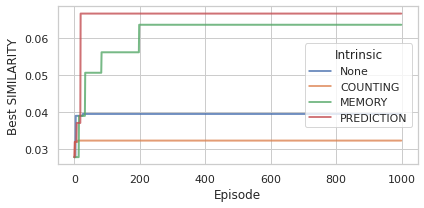

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6, 3))

sns.lineplot(data=df_hist_best,
             x='Episode', y=f'Best {PROPERTY_NAME}', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 3. History of intrinsic reward values

In [13]:
def get_history_of_intrinsic_reward_values(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'curiosity_error_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [14]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    intrinsic_reward_scores = get_history_of_intrinsic_reward_values(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(intrinsic_reward_scores)),
        'Average intrinsic reward':intrinsic_reward_scores,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_intrinsic = pd.concat(frames, ignore_index=True)

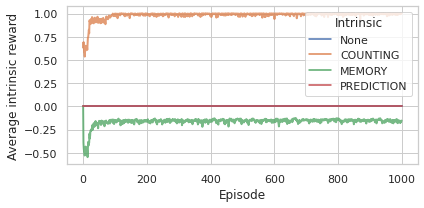

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6, 3))

sns.lineplot(data=df_hist_intrinsic,
             x='Episode', y='Average intrinsic reward', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 4. History of average property scores

In [16]:
def get_history_of_average_property_scores(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'molecule_property_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [17]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_average_property_scores(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        f'Average {PROPERTY_NAME}':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_avg = pd.concat(frames, ignore_index=True)

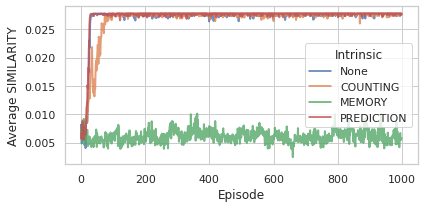

In [18]:
fig, ax = plt.subplots(1,1,figsize=(6, 3))

sns.lineplot(data=df_hist_avg,
             x='Episode', y=f'Average {PROPERTY_NAME}', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 5. History of reward values

In [19]:
def get_history_of_reward_values(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'reward_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [20]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_reward_values(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        'Reward':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_reward = pd.concat(frames, ignore_index=True)

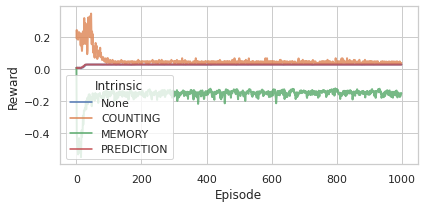

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6, 3))

sns.lineplot(data=df_hist_reward,
             x='Episode', y='Reward', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()